In [1]:
from pyiron_contrib.workflow.node import Node, node
from pyiron_contrib.workflow.workflow import Workflow

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


# Pyiron workflows: Introduction and Syntax

Here we will highlight:
- How to instantiate a node
- How to make reusable node classes
- A variety of ways to set node channel data
- How to connect node inputs and outputs together
- The four ways of adding nodes to a workflow
- How to import and use pre-defined nodes 

## Instantiating a node

Nodes can be defined on-the-fly by passing any callable to the `Node` class, along with a string (tuple of strings) giving names for the output value(s).

In [2]:
def plus_minus_one(x):
    return x+1, x-1

try:
    pm_node = Node(plus_minus_one, "p1", "m1")
except TypeError:
    print("This won't quite work yet!")

This won't quite work yet!


Unless you specify additional kwargs (i.e. `run_automatically=False`, `update_on_instantiation=False`), your node will try to execute the function immediately! In the example above, this resulted in a `TypeError` (from `None + 1`).

Instead of just preventing the update by decree, we could (a) provide default values for our function, and/or (b) provide type hints for our function (the node will only run automatically once all the input data has the right type (where specified)).
Let's do both

In [3]:
def plus_minus_one(x: int | float = 1) -> tuple[int | float, int | float]:
    return x+1, x-1

pm_node = Node(plus_minus_one, "p1", "m1")

When we create a node, input and output data channels are constructed automatically from the signature and type hints of the function, and the output labels.

In [4]:
print(pm_node.inputs.labels, pm_node.outputs.labels)

['x'] ['p1', 'm1']


In [5]:
print(pm_node.inputs.x.type_hint)

int | float


And now that it could safely update right away, we can look at the output:

In [6]:
print(pm_node.outputs.to_value_dict())

{'p1': 2, 'm1': 0}


We can assign new data to the input channels with the `update` method, or with `=`:

In [7]:
pm_node.inputs.x.update(2)
print(pm_node.outputs.to_value_dict())

{'p1': 3, 'm1': 1}


In [8]:
pm_node.inputs.x = 3
print(pm_node.outputs.to_value_dict())

{'p1': 4, 'm1': 2}


## Reusable node classes

If we're going to use a node many times, we may want to define a new sub-class of `Node` to handle this.

The can be done directly by inheriting from `Node` and overriding it's `__init__` function so that the core functionality of the node (i.e. the node function and output labels) are set in stone. Here we do this very succinctly using `functools.partialmethod`:

In [9]:
from functools import partialmethod

class Adder(Node):
    @staticmethod
    def adder(x: int|float, y: int|float) -> int|float:
        return x + y
    
    __init__ = partialmethod(Node.__init__, adder, "sum")

Note that we only need a single string for `output_labels` when we only return a single value, and that the node's `label` takes (by default) the name of the `node_function`:

In [10]:
add = Adder(x=2, y=3)
print(add.label)
print(add.outputs.sum)

adder
5


Here we have also shown another way to initialize data -- right at instantiation as a kwarg.
Kwarg values matching the node function signature will be passed from the node initializer to the channels.

We can also define new node classes _even more succinctly_ by using the `@node` decorator! Under the hood it is doing the same stuff we just did above, but here all you need to do is decorate the function you want to have as a node and provide labels for the output:

In [11]:
@node("difference")
def subtractor(x: int|float, y: int|float) -> int|float:
    return x - y

In [12]:
sub = subtractor(x=2, y=3)
print("class name =",sub.__class__.__name__)
print("label =", sub.label)
print("z =", sub.outputs.difference)

class name = Subtractor
label = subtractor
z = -1


Note that the new class uses a CamelCase version of the function name, has the method-resolution-order (i.e. parentage) that we expect.

## Node connections 

Next, we want to make connections between nodes. Instead of `update` we can use the `connect` method to accomplish this, or we can do it with the other syntactic sugar we saw for regular data (i.e. direct attribute access or using kwargs at instantiation):

In [13]:
upstream = Adder(x=0, y=0)

ds1 = Node(plus_minus_one, "p1", "m1")
ds1.inputs.x.connect(upstream.outputs.sum)

ds2 = Node(plus_minus_one, "p1", "m1")
ds2.inputs.x = upstream.outputs.sum

ds3 = Node(plus_minus_one, "p1", "m1", x=upstream.outputs.sum)

print(ds1.outputs.p1, ds2.outputs.p1, ds3.outputs.p1)
upstream.inputs.x = 10
print(ds1.outputs.p1, ds2.outputs.p1, ds3.outputs.p1)

1 1 1
11 11 11


## Adding nodes to a workflow

We use workflows to hold together collections of related and connected nodes.

All five of the following approaches are equivalent ways to add a node to a workflow:

In [14]:
n1 = Node(plus_minus_one, "p1", "m1", label="n1")

wf = Workflow("my_wf", n1)  # As args at init
wf.add.Node(plus_minus_one, "p1", "m1", label="n2")  # Instantiating from the node adder
wf.add(Node(plus_minus_one, "p1", "m1", label="n3"))  # Instantiating then passing to node adder
wf.n4 = Node(plus_minus_one, "p1", "m1", label="whatever_n4_gets_used")  # By attribute
Node(plus_minus_one, "p1", "m1", label="n5", workflow=wf)  # By passing the workflow

wf.nodes

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/workflow.py:167: UserWarning: Reassigning the node whatever_n4_gets_used to the label n4 when adding it to the workflow my_wf.
  warn(


{'n1': <pyiron_contrib.workflow.node.Node at 0x149862b10>,
 'n2': <pyiron_contrib.workflow.node.Node at 0x149860f90>,
 'n3': <pyiron_contrib.workflow.node.Node at 0x149861290>,
 'n4': <pyiron_contrib.workflow.node.Node at 0x1495f1610>,
 'n5': <pyiron_contrib.workflow.node.Node at 0x149868bd0>}

# Flow control

By default, when a node runs and updates its output, this triggers outputs in all downstream connections. This is useful when all your node functions are small and light, but there may come times when you want something other than this simple "push" flow.

In addition to input and output data channels, nodes also have "signal" channels available. Input signals are bound to a callback function (typically one of its node's methods), and output signals trigger the callbacks for all the input signal channels they're connected to.

Standard nodes have a `run` input signal (which is, unsurprisingly, bound to the `run` method), and a `ran` output signal (which, again, hopefully with no great surprise, is triggered at the end of the `run` method.)

Below is a super simple example of how these signal channels can be used to delay execution and manually control flow:

In [2]:
@node("y")
def linear(x):
    return x

@node("z")
def times_two(y):
    return 2 * y

l = linear(x=1)
t2 = times_two(
    y=l.outputs.y, update_on_instantiation=False, run_automatically=False
)
print(t2.inputs.y, t2.outputs.z)

1 None


Now the input of `t2` got updated when the connection is made, but we told this node not to do any automatic updates, so the output has its uninitialized value of `None`.

Often, you will probably want to have nodes with data connections to have signal connections, but this is not strictly required. Here, we'll introduce a third node to control the execution of `t2`.

Note that we have all the same syntacic sugar from data channels when creating connections between signal channels.

In [3]:
@node("void")
def control():
    return

c = control()
t2.signals.input.run = c.signals.output.ran
c.run()
print(t2.outputs.z.value)

2


# Example with pre-built nodes

Currently we have a handfull of pre-build nodes available for import from the `nodes` package. Let's use these to quickly put together a workflow for looking at some MD data.

In [15]:
from pyiron_contrib.workflow import nodes

In [16]:
wf = Workflow("with_prebuilt")

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/workflow.py:167: UserWarning: Reassigning the node bulk_structure to the label structure when adding it to the workflow with_prebuilt.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/workflow.py:167: UserWarning: Reassigning the node lammps to the label engine when adding it to the workflow with_prebuilt.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 333


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/workflow.py:167: UserWarning: Reassigning the node calc_md to the label calc when adding it to the workflow with_prebuilt.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/workflow.py:167: UserWarning: Reassigning the node scatter to the label plot when adding it to the workflow with_prebuilt.
  warn(


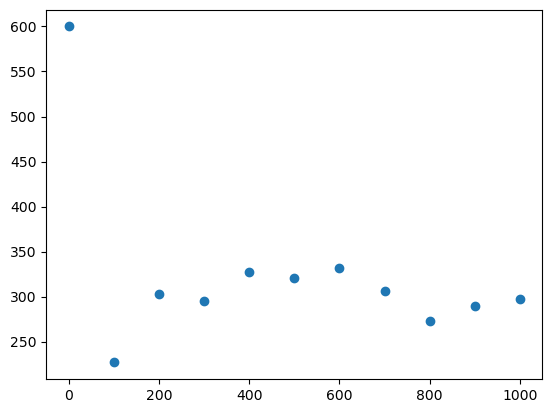

In [17]:
wf.structure = nodes.bulk_structure(repeat=3, cubic=True, element="Al")
wf.engine = nodes.lammps(structure=wf.structure.outputs.structure)
wf.calc = nodes.calc_md(job=wf.engine.outputs.job)
wf.plot = nodes.scatter(
    x=wf.calc.outputs.steps, 
    y=wf.calc.outputs.temperature
)